# LogSumExp Smooth Approximation for $C_{1a}$

Replace the non-smooth objective $\max_k c_k$ with the smooth surrogate:
$$\mathrm{LSE}_\beta(c) = \frac{1}{\beta} \log \sum_k \exp(\beta \, c_k)$$

**Properties:**
- $\max_k c_k \le \mathrm{LSE}_\beta(c) \le \max_k c_k + \frac{\log n}{\beta}$
- Gradient: $\nabla_{c_k} \mathrm{LSE}_\beta = \mathrm{softmax}(\beta \, c)_k$ — distributes gradient across all near-peak positions
- Addresses peak-locking (bottleneck S4) by smoothing the $\arg\max$ discontinuity

**Strategy:** $\beta$-continuation — start with small $\beta$ (smooth landscape), gradually increase toward the true max.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from src.representations import StepFunction
from src.convolution import peak_autoconv_exact

In [2]:
# === Core functions ===

def project_simplex(x):
    """Project x onto the probability simplex {x >= 0, sum(x) = 1}."""
    n = len(x)
    u = np.sort(x)[::-1]
    cssv = np.cumsum(u) - 1.0
    rho = np.nonzero(u * np.arange(1, n + 1) > cssv)[0][-1]
    tau = cssv[rho] / (rho + 1.0)
    return np.maximum(x - tau, 0.0)


def compute_autoconv_coeffs(x, P):
    """Compute c_k = 2P * sum_{i+j=k} x_i x_j for k=0,...,2(P-1)."""
    return np.convolve(x, x) * (2 * P)


def logsumexp_stable(c, beta):
    """Numerically stable LogSumExp: (1/beta) * log(sum(exp(beta * c)))."""
    bc = beta * c
    bc_max = np.max(bc)
    return bc_max / beta + np.log(np.sum(np.exp(bc - bc_max))) / beta


def softmax_weights(c, beta):
    """Softmax weights: exp(beta * c_k) / sum(exp(beta * c_j))."""
    bc = beta * c
    bc -= np.max(bc)  # stability
    e = np.exp(bc)
    return e / np.sum(e)


def lse_objective(x, P, beta):
    """LSE_beta of autoconvolution coefficients."""
    c = compute_autoconv_coeffs(x, P)
    return logsumexp_stable(c, beta)


def lse_gradient(x, P, beta):
    """Gradient of LSE_beta(c(x)) w.r.t. x on the simplex.
    
    Chain rule: d(LSE)/d(x_i) = sum_k w_k * d(c_k)/d(x_i)
    where w_k = softmax(beta * c)_k and d(c_k)/d(x_i) = 2 * (2P) * x_{k-i}.
    
    This is equivalent to: g_i = 2 * (2P) * sum_k w_k * x_{k-i}
    which is the correlation of the softmax weights with x.
    """
    c = compute_autoconv_coeffs(x, P)
    w = softmax_weights(c, beta)
    # d(c_k)/d(x_i) = 2*(2P)*x_{k-i} when 0 <= k-i < P
    # So g_i = 2*(2P) * sum_k w_k * x_{k-i} = 2*(2P) * (w \star x)[i]
    # where \star denotes correlation (flip-convolve)
    # correlate(w, x) at lag i = sum_k w[k] * x[k-i]
    g = np.correlate(w, x, mode='full')
    # The output has length len(w)+len(x)-1. We need indices corresponding
    # to i=0,...,P-1. In np.correlate(w,x,'full'), output[k] = sum_j w[j+k]*x[j]
    # for k = 0,...,len(w)-1. But we want sum_k w[k]*x[k-i].
    # Let's just compute it directly for clarity.
    n = len(x)
    n_c = len(c)
    g = np.zeros(n)
    for i in range(n):
        for k in range(n_c):
            j = k - i
            if 0 <= j < n:
                g[i] += w[k] * x[j]
    g *= 2.0 * (2 * P)
    return g


def lse_gradient_fast(x, P, beta):
    """Vectorized gradient using convolution.
    
    g_i = 2*(2P) * sum_k w_k * x_{k-i}
    This is the cross-correlation of w with x, evaluated at lags 0..P-1.
    Equivalently: g = 2*(2P) * convolve(w, x[::-1])[P-1 : 2P-1]
    """
    c = compute_autoconv_coeffs(x, P)
    w = softmax_weights(c, beta)
    # w has length 2P-1, x has length P
    # We want g[i] = sum_k w[k] * x[k-i] for i=0..P-1
    # = (w \star x)[i] where \star is cross-correlation
    # Using numpy: correlate(w, x, 'full') gives output at lag m
    # But it's easier to use convolve with reversed x:
    # convolve(w, x[::-1]) at index (i + P - 1) gives sum_k w[k] * x[k-i]
    conv = np.convolve(w, x[::-1])
    P_len = len(x)
    g = conv[P_len - 1 : 2 * P_len - 1] * 2.0 * (2 * P)
    return g


# Verify gradient implementations match
np.random.seed(42)
P_test = 10
x_test = np.random.dirichlet(np.ones(P_test))
beta_test = 10.0
g_slow = lse_gradient(x_test, P_test, beta_test)
g_fast = lse_gradient_fast(x_test, P_test, beta_test)
print(f"Gradient check (slow vs fast): max diff = {np.max(np.abs(g_slow - g_fast)):.2e}")

# Verify gradient with finite differences
eps = 1e-7
g_fd = np.zeros(P_test)
for i in range(P_test):
    x_plus = x_test.copy(); x_plus[i] += eps
    x_minus = x_test.copy(); x_minus[i] -= eps
    g_fd[i] = (lse_objective(x_plus, P_test, beta_test) - lse_objective(x_minus, P_test, beta_test)) / (2 * eps)
print(f"Gradient check (analytic vs FD): max diff = {np.max(np.abs(g_fast - g_fd)):.2e}")
print("Gradient implementations verified.")

Gradient check (slow vs fast): max diff = 0.00e+00
Gradient check (analytic vs FD): max diff = 2.20e-09
Gradient implementations verified.


In [3]:
# === LSE with beta-continuation on simplex ===

def optimize_lse_continuation(P, beta_schedule, n_iters_per_beta=5000,
                               lr_init=0.01, n_restarts=5, verbose=True):
    """
    Projected gradient descent with LSE objective and beta-continuation.
    
    Start with small beta (smooth), increase to large beta (close to max).
    Each beta stage warm-starts from the previous solution.
    """
    best_true_val = np.inf
    best_x = None
    
    for restart in range(n_restarts):
        x = np.random.dirichlet(np.ones(P))
        
        for stage, beta in enumerate(beta_schedule):
            lr = lr_init
            best_stage_val = np.inf
            best_stage_x = x.copy()
            no_improve = 0
            
            for t in range(n_iters_per_beta):
                g = lse_gradient_fast(x, P, beta)
                
                # Adaptive step size with backtracking
                step = lr / (1 + t * 1e-4)
                x_new = project_simplex(x - step * g)
                
                fval_new = lse_objective(x_new, P, beta)
                fval_old = lse_objective(x, P, beta)
                
                if fval_new < fval_old:
                    x = x_new
                    if fval_new < best_stage_val:
                        best_stage_val = fval_new
                        best_stage_x = x.copy()
                        no_improve = 0
                    else:
                        no_improve += 1
                else:
                    # Reduce step size
                    lr *= 0.5
                    if lr < 1e-12:
                        break
                    no_improve += 1
                
                if no_improve > 500:
                    break
            
            x = best_stage_x  # warm-start next stage
            lr = lr_init  # reset learning rate for new beta
        
        # Evaluate true objective (max, not LSE)
        true_val = np.max(compute_autoconv_coeffs(x, P))
        if verbose:
            print(f"  Restart {restart}: true obj = {true_val:.6f}")
        
        if true_val < best_true_val:
            best_true_val = true_val
            best_x = x.copy()
    
    return best_true_val, best_x


print("Optimizer defined.")

Optimizer defined.


In [4]:
# === Compare: Polyak subgradient baseline (from primal_optimizer) ===

def polyak_subgradient(P, n_iters=50000, n_restarts=5, targets=(1.50, 1.49, 1.48)):
    """Polyak subgradient on the simplex (baseline from primal_optimizer)."""
    best_val = np.inf
    best_x = None
    for target in targets:
        for restart in range(n_restarts):
            x = np.random.dirichlet(np.ones(P))
            best_local = np.inf
            best_local_x = x.copy()
            for t in range(n_iters):
                c = compute_autoconv_coeffs(x, P)
                fval = np.max(c)
                if fval < best_local:
                    best_local = fval
                    best_local_x = x.copy()
                k_star = np.argmax(c)
                n_x = len(x)
                g = np.zeros(n_x)
                for i in range(n_x):
                    j = k_star - i
                    if 0 <= j < n_x:
                        g[i] += 2 * (2 * P) * x[j]
                gnorm2 = np.dot(g, g)
                if gnorm2 < 1e-20:
                    break
                step = (fval - target) / gnorm2
                if step < 0:
                    step = 1e-4 / (1 + t)
                x = project_simplex(x - step * g)
            if best_local < best_val:
                best_val = best_local
                best_x = best_local_x.copy()
    return best_val, best_x


print("Baseline defined.")

Baseline defined.


In [5]:
# === Run comparison ===

P_values = [10, 20, 30, 50, 75, 100, 150, 200]

# Beta schedule: geometric progression from smooth to sharp
beta_schedule = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

results = {}
np.random.seed(123)

for P in P_values:
    print(f"\n{'='*60}")
    print(f"P = {P}")
    print(f"{'='*60}")
    
    # LSE continuation
    print(f"  LSE continuation (beta: {beta_schedule[0]} -> {beta_schedule[-1]}):")
    val_lse, x_lse = optimize_lse_continuation(
        P, beta_schedule, n_iters_per_beta=5000, lr_init=0.01, n_restarts=5
    )
    
    # Validate with exact peak computation
    edges = np.linspace(-0.25, 0.25, P + 1)
    bin_width = 0.5 / P
    sf_lse = StepFunction.from_heights(edges, x_lse / bin_width)
    exact_lse = peak_autoconv_exact(sf_lse)
    print(f"  LSE result: simplex obj = {val_lse:.6f}, exact = {exact_lse:.6f}")
    
    # Polyak baseline
    print(f"  Polyak subgradient baseline:")
    val_poly, x_poly = polyak_subgradient(P, n_iters=50000, n_restarts=5)
    sf_poly = StepFunction.from_heights(edges, x_poly / bin_width)
    exact_poly = peak_autoconv_exact(sf_poly)
    print(f"  Polyak result: simplex obj = {val_poly:.6f}, exact = {exact_poly:.6f}")
    
    delta = exact_lse - exact_poly
    winner = "LSE" if delta < 0 else "Polyak" if delta > 0 else "Tie"
    print(f"  >> Winner: {winner} (delta = {delta:+.6f})")
    
    results[P] = {
        'lse': (exact_lse, x_lse),
        'polyak': (exact_poly, x_poly),
    }


P = 10
  LSE continuation (beta: 1 -> 1000):
  Restart 0: true obj = 1.566730
  Restart 1: true obj = 1.566730
  Restart 2: true obj = 1.566730
  Restart 3: true obj = 1.571862
  Restart 4: true obj = 1.566730
  LSE result: simplex obj = 1.566730, exact = 1.566730
  Polyak subgradient baseline:
  Polyak result: simplex obj = 1.569636, exact = 1.569636
  >> Winner: LSE (delta = -0.002907)

P = 20
  LSE continuation (beta: 1 -> 1000):
  Restart 0: true obj = 1.544028
  Restart 1: true obj = 1.544028
  Restart 2: true obj = 1.544028
  Restart 3: true obj = 1.544028
  Restart 4: true obj = 1.541477
  LSE result: simplex obj = 1.541477, exact = 1.541477
  Polyak subgradient baseline:
  Polyak result: simplex obj = 1.541465, exact = 1.541465
  >> Winner: Polyak (delta = +0.000012)

P = 30
  LSE continuation (beta: 1 -> 1000):
  Restart 0: true obj = 1.536073
  Restart 1: true obj = 1.534617
  Restart 2: true obj = 1.528100
  Restart 3: true obj = 1.535595
  Restart 4: true obj = 1.534617
  

In [6]:
# === Results table ===

print(f"{'P':>5} | {'LSE (exact)':>14} | {'Polyak (exact)':>14} | {'Delta':>10} | {'Winner':>8}")
print('-' * 62)
for P in P_values:
    r = results[P]
    v_lse = r['lse'][0]
    v_poly = r['polyak'][0]
    delta = v_lse - v_poly
    winner = "LSE" if delta < 0 else "Polyak" if delta > 0 else "Tie"
    print(f"{P:>5} | {v_lse:>14.6f} | {v_poly:>14.6f} | {delta:>+10.6f} | {winner:>8}")

print(f"\nBest known upper bound: 1.5029")

    P |    LSE (exact) | Polyak (exact) |      Delta |   Winner
--------------------------------------------------------------
   10 |       1.566730 |       1.569636 |  -0.002907 |      LSE
   20 |       1.541477 |       1.541465 |  +0.000012 |   Polyak
   30 |       1.528100 |       1.530947 |  -0.002847 |      LSE
   50 |       1.523722 |       1.529741 |  -0.006019 |      LSE
   75 |       1.515668 |       1.522229 |  -0.006560 |      LSE
  100 |       1.516776 |       1.523832 |  -0.007056 |      LSE
  150 |       1.513697 |       1.524894 |  -0.011197 |      LSE
  200 |       1.512921 |       1.520345 |  -0.007424 |      LSE

Best known upper bound: 1.5029


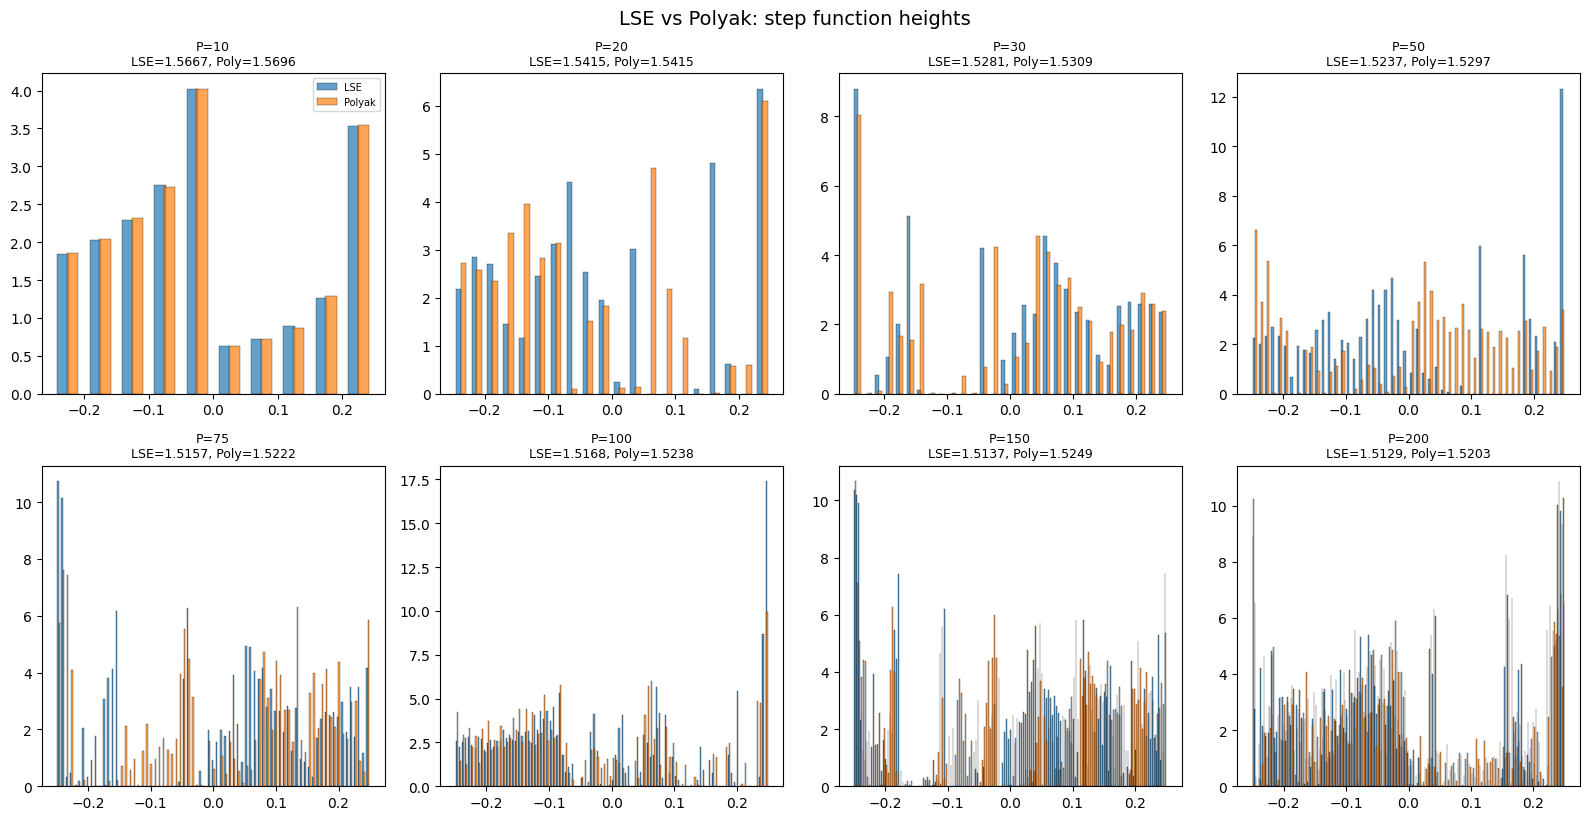

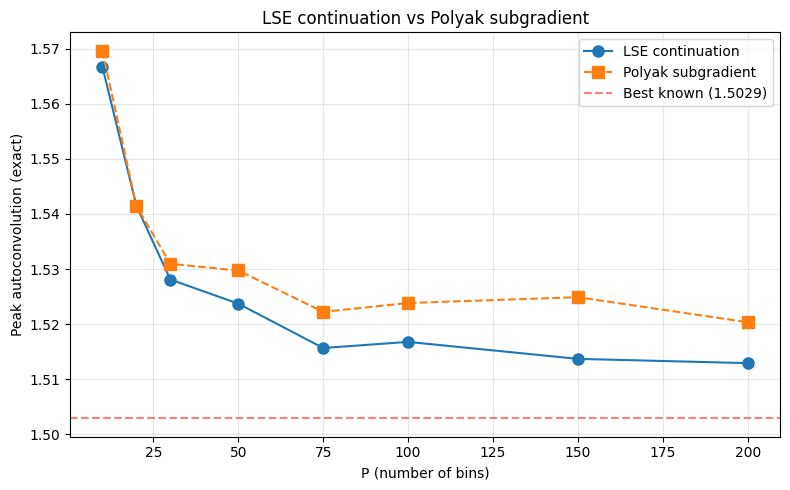

In [7]:
# === Visualization ===

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, P in enumerate(P_values):
    ax = axes[idx]
    edges = np.linspace(-0.25, 0.25, P + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    bin_width = 0.5 / P
    
    x_lse = results[P]['lse'][1]
    x_poly = results[P]['polyak'][1]
    
    ax.bar(centers - bin_width*0.15, x_lse / bin_width, width=bin_width*0.35,
           alpha=0.7, label='LSE', color='C0', edgecolor='k', linewidth=0.3)
    ax.bar(centers + bin_width*0.15, x_poly / bin_width, width=bin_width*0.35,
           alpha=0.7, label='Polyak', color='C1', edgecolor='k', linewidth=0.3)
    
    v_lse = results[P]['lse'][0]
    v_poly = results[P]['polyak'][0]
    ax.set_title(f'P={P}\nLSE={v_lse:.4f}, Poly={v_poly:.4f}', fontsize=9)
    if idx == 0:
        ax.legend(fontsize=7)

plt.tight_layout()
plt.suptitle('LSE vs Polyak: step function heights', y=1.02, fontsize=14)
plt.savefig('logsumexp_vs_polyak_heights.png', dpi=150, bbox_inches='tight')
plt.show()

# Convergence comparison
fig, ax = plt.subplots(figsize=(8, 5))
Ps = sorted(results.keys())
lse_vals = [results[P]['lse'][0] for P in Ps]
poly_vals = [results[P]['polyak'][0] for P in Ps]

ax.plot(Ps, lse_vals, 'o-', label='LSE continuation', markersize=8)
ax.plot(Ps, poly_vals, 's--', label='Polyak subgradient', markersize=8)
ax.axhline(1.5029, color='r', linestyle='--', alpha=0.5, label='Best known (1.5029)')
ax.set_xlabel('P (number of bins)')
ax.set_ylabel('Peak autoconvolution (exact)')
ax.set_title('LSE continuation vs Polyak subgradient')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('logsumexp_vs_polyak_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# === Ablation: effect of beta schedule ===
# Test different continuation strategies at P=50

P_abl = 50
schedules = {
    'aggressive': [1, 10, 100, 1000],
    'moderate': [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
    'gentle': [1, 1.5, 2, 3, 5, 7, 10, 15, 20, 30, 50, 75, 100, 150, 200, 300, 500, 750, 1000],
    'fixed_low': [10] * 10,
    'fixed_high': [1000] * 10,
}

print(f"Beta schedule ablation at P = {P_abl}")
print(f"{'Schedule':>15} | {'Stages':>6} | {'Exact obj':>12}")
print('-' * 42)

np.random.seed(456)
for name, sched in schedules.items():
    val, x = optimize_lse_continuation(
        P_abl, sched, n_iters_per_beta=3000, lr_init=0.01, n_restarts=3, verbose=False
    )
    edges = np.linspace(-0.25, 0.25, P_abl + 1)
    bin_width = 0.5 / P_abl
    sf = StepFunction.from_heights(edges, x / bin_width)
    exact = peak_autoconv_exact(sf)
    print(f"{name:>15} | {len(sched):>6} | {exact:>12.6f}")

Beta schedule ablation at P = 50
       Schedule | Stages |    Exact obj
------------------------------------------
     aggressive |      4 |     1.526577
       moderate |     10 |     1.524093
         gentle |     19 |     1.526086
      fixed_low |     10 |     1.600126
     fixed_high |     10 |     1.529043


In [9]:
# === Hybrid: LSE warm-start -> Polyak polish ===
# Use LSE continuation to find a good basin, then polish with Polyak subgradient

def hybrid_lse_polyak(P, beta_schedule, n_iters_lse=3000, n_iters_polyak=30000,
                      n_restarts=5, targets=(1.50, 1.49, 1.48)):
    best_val = np.inf
    best_x = None
    
    for restart in range(n_restarts):
        # Phase 1: LSE continuation
        x = np.random.dirichlet(np.ones(P))
        for beta in beta_schedule:
            lr = 0.01
            best_stage_x = x.copy()
            best_stage_val = lse_objective(x, P, beta)
            no_improve = 0
            for t in range(n_iters_lse):
                g = lse_gradient_fast(x, P, beta)
                step = lr / (1 + t * 1e-4)
                x_new = project_simplex(x - step * g)
                fval_new = lse_objective(x_new, P, beta)
                if fval_new < lse_objective(x, P, beta):
                    x = x_new
                    if fval_new < best_stage_val:
                        best_stage_val = fval_new
                        best_stage_x = x.copy()
                        no_improve = 0
                    else:
                        no_improve += 1
                else:
                    lr *= 0.5
                    if lr < 1e-12:
                        break
                    no_improve += 1
                if no_improve > 300:
                    break
            x = best_stage_x
        
        # Phase 2: Polyak subgradient polish from LSE solution
        for target in targets:
            x_polish = x.copy()
            best_local = np.max(compute_autoconv_coeffs(x_polish, P))
            best_local_x = x_polish.copy()
            for t in range(n_iters_polyak):
                c = compute_autoconv_coeffs(x_polish, P)
                fval = np.max(c)
                if fval < best_local:
                    best_local = fval
                    best_local_x = x_polish.copy()
                k_star = np.argmax(c)
                n_x = len(x_polish)
                g = np.zeros(n_x)
                for i in range(n_x):
                    j = k_star - i
                    if 0 <= j < n_x:
                        g[i] += 2 * (2 * P) * x_polish[j]
                gnorm2 = np.dot(g, g)
                if gnorm2 < 1e-20:
                    break
                step_size = (fval - target) / gnorm2
                if step_size < 0:
                    step_size = 1e-4 / (1 + t)
                x_polish = project_simplex(x_polish - step_size * g)
            
            if best_local < best_val:
                best_val = best_local
                best_x = best_local_x.copy()
    
    return best_val, best_x


print("Hybrid optimizer defined.")

Hybrid optimizer defined.


In [10]:
# === Run hybrid comparison ===

P_values_hybrid = [20, 50, 100, 200]
beta_sched = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

results_hybrid = {}
np.random.seed(789)

for P in P_values_hybrid:
    print(f"\nP = {P}")
    edges = np.linspace(-0.25, 0.25, P + 1)
    bin_width = 0.5 / P
    
    # Hybrid
    val_hyb, x_hyb = hybrid_lse_polyak(P, beta_sched, n_restarts=5)
    sf_hyb = StepFunction.from_heights(edges, x_hyb / bin_width)
    exact_hyb = peak_autoconv_exact(sf_hyb)
    
    # Pure Polyak
    val_poly, x_poly = polyak_subgradient(P, n_iters=50000, n_restarts=5)
    sf_poly = StepFunction.from_heights(edges, x_poly / bin_width)
    exact_poly = peak_autoconv_exact(sf_poly)
    
    delta = exact_hyb - exact_poly
    winner = "Hybrid" if delta < 0 else "Polyak"
    print(f"  Hybrid: {exact_hyb:.6f}, Polyak: {exact_poly:.6f}, delta={delta:+.6f} ({winner})")
    
    results_hybrid[P] = {'hybrid': exact_hyb, 'polyak': exact_poly}

print(f"\n{'P':>5} | {'Hybrid':>12} | {'Polyak':>12} | {'Delta':>10}")
print('-' * 48)
for P in P_values_hybrid:
    r = results_hybrid[P]
    delta = r['hybrid'] - r['polyak']
    print(f"{P:>5} | {r['hybrid']:>12.6f} | {r['polyak']:>12.6f} | {delta:>+10.6f}")


P = 20
  Hybrid: 1.542197, Polyak: 1.545416, delta=-0.003219 (Hybrid)

P = 50
  Hybrid: 1.524232, Polyak: 1.524844, delta=-0.000612 (Hybrid)

P = 100
  Hybrid: 1.518748, Polyak: 1.522934, delta=-0.004186 (Hybrid)

P = 200
  Hybrid: 1.515799, Polyak: 1.519921, delta=-0.004122 (Hybrid)

    P |       Hybrid |       Polyak |      Delta
------------------------------------------------
   20 |     1.542197 |     1.545416 |  -0.003219
   50 |     1.524232 |     1.524844 |  -0.000612
  100 |     1.518748 |     1.522934 |  -0.004186
  200 |     1.515799 |     1.519921 |  -0.004122
